# SET UP ENVIRONMENT

In [1]:
# Uncomment the lines below to install the required packages if needed
#Requires python 3.8

# Install pandas for data manipulation
#!conda install -y pandas==1.1.5

# Install numpy for numerical computations
#!conda install -y numpy=1.19.5

# Install matplotlib for plotting
#!conda install -y matplotlib==3.3.4

# Install nltk for text preprocessing
#!conda install -y nltk

# Install emoji for handling emojis in text
#!pip install emoji

# Install TensorFlow for deep learning (including Keras)
#!conda install -y tensorflow=2.3.0

# Install scikit-learn for machine learning utilities
#!conda install -y scikit-learn

# Install gensim for Word2Vec embeddings
#!conda install -y gensim

# Install packaging for version checking
#!pip install packaging

# Install Tensorflow Federated Package
#!pip install tensorflow-federated


# CONSTANTS

In [ ]:
no_reviews = None  # set to `None` to read all reviews
max_words = 5000   # Size of the vocabulary - the most common words to be used as features
embedding_size = 300  # Size of the embedding vectors
prop_val = 0.2        # Proportion of data for the validation set
prop_test = 0.2       # Proportion of data for the testing set
no_epochs = 10        # Number of training cycles for the network
# Path to the CSV file (Adjust as needed)
data_path = r""

# IMPORTS

In [3]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import math

import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import emoji
# Ensures that NLTK resources are downloaded (first-time use only)
nltk.download('stopwords')
nltk.download('wordnet')

import tensorflow as tf
import tensorflow_federated as tff

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

import nest_asyncio

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split

import gensim
from gensim.models import KeyedVectors
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess
#from gensim.models import Word2Vec

from packaging import version
# Check gensim version
if version.parse(gensim.__version__) < version.parse("4.3.0"):
    print("Minimum Gensim version required: 4.3.0 Installed Gensim version is", gensim.__version__)
    print("You need to update Gensim using pip install -U gensim")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jlwon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jlwon\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# DATA LOADING AND PREPROCESSING

In [4]:
# Function to read the dataset

def read_data_from_csv(file_path, no_reviews=None):
    # Read the data from the CSV file
    df = pd.read_csv(file_path)
    
    # If no_reviews is specified, limit the number of reviews read
    if no_reviews is not None:
        df = df.iloc[:no_reviews]  # Get the first `no_reviews` entries
    
    return df

In [5]:
# Function to Pre-Process the data

def preprocess_data(df):

    # Remove rows where 'review_body' is NaN
    df.dropna(subset=['review_body'], inplace=True)
    
    stop_words = set(stopwords.words('english'))
    
    lemmatizer = WordNetLemmatizer()

    def clean_text(text):
        text = text.lower()  # Convert to lowercase
        text = re.sub(r'http\S+', '', text)  # Remove URLs
        text = re.sub(r'@\S+', '', text)  # Remove mentions
        text = re.sub(r'#\S+', '', text)  # Remove hashtags
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = emoji.demojize(text, delimiters=("", ""))  # Convert emojis to words
        
        
        # Uses the simple_process fucntion of Gensim library to split the text into tokens
        tokens = simple_preprocess(text)

        # Lemmatise the tokens, remove stopwords, and filter out short words with less than 3 characters.
        # Lemmatise the tokens to get their root form (lemmas), removing inflectional endings only and 
        # returning the base or dictionary form of a word, which is known as the lemma. For instance, 
        # 'running' becomes 'run'. Also, remove stopwords, which are commonly used words that are unlikely 
        # to carry much meaning, such as 'and' or 'the'. Exclude words shorter than three characters to 
        # eliminate most conjunctions, prepositions, and other short words that typically don't contribute 
        # to sentiment analysis. This process reduces noise and dimensionality in the text data.
        # This helps in focusing on more meaningful words.
        
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
        
        # Return the cleaned tokens if the review is not empty, else None
        return tokens if tokens else None
            
    # Apply preprocessing to each review
    df['processed_review'] = df['review_body'].apply(clean_text)
    
    # Handle empty results
    # Remove rows where the reviews ended up being empty after preprocessing
    df = df.loc[~df['processed_review'].isna()].copy()
    
    # Convert ratings to binary: 1 if greater than 2, else 0
    # Ratings of 3, 4, or 5 (above 2) are considered positive (1).
    # Ratings of 1 or 2 (2 or below) are considered negative (0).
    df['binary_stars'] = df['stars'].apply(lambda x: 1 if x > 2 else 0)

    
    reviews = df['processed_review'].tolist()
    ratings = df['binary_stars'].tolist()
    
    return reviews, ratings

In [6]:
#Function for Distribution Analysis of reviews' length

def analyze_review_lengths(reviews):
    # Array to hold counts of review lengths up to 249 words
    counts = np.zeros(250)
    # To count reviews longer than 249 words
    above = 0
    total = 0

    # Analyse lengths
    for review in reviews:
        len_review = len(review)
        total += len_review
        if len_review < 250:
            counts[len_review] += 1
        else:
            above += 1

    average_len = total / len(reviews) if reviews else 0
    print("Average length of reviews =", average_len)
    print("Reviews longer than 249 words =", above)

    # Plotting the distribution
    plt.figure(figsize=(10, 5))
    plt.bar(range(250), counts, color='blue')
    plt.xlabel("Number of words")
    plt.ylabel("Frequency")
    plt.title("Distribution of Review Lengths")
    plt.show()

    return average_len 

In [7]:
# Function to split the data in training, testing and validating sets

def split_data(reviews, ratings, prop_val, prop_test):
    # First, split into training and a temporary set (test + validation)
    x_train, x_temp, y_train, y_temp = train_test_split(
        reviews, ratings, test_size=prop_val + prop_test, random_state=42)
    
    # Split the temporary set into validation and test sets
    x_val, x_test, y_val, y_test = train_test_split(
        x_temp, y_temp, test_size=prop_test / (prop_val + prop_test), random_state=42)
    
    return x_train, y_train, x_val, y_val, x_test, y_test

In [8]:
# Data loading, preprocessing and splitting

# Use the function to read the data
df = read_data_from_csv(data_path)

# Preprocess the data
reviews, ratings = preprocess_data(df)

print(f"Total number of reviews read: {len(reviews)}")

# Display sample reviews and ratings
print("\nSample reviews with ratings:")
for i in range(min(10, len(reviews))):
    print(f"Review {i + 1}: Rating: {ratings[i]}, Review: {' '.join(reviews[i])}")

Total number of reviews read: 21949

Sample reviews with ratings:
Review 1: Rating: 1, Review: best matter great platform easy simple use one crypto offer actually call phone number get someone question like highly recommend customer year good thing say celsius network
Review 2: Rating: 1, Review: looking best earn steady yield better place celsius network app easy use understand recent update well company led great ceo fully engaged celsius community mission celsius good well live much reward compound pay weekly
Review 3: Rating: 0, Review: despise much transferring wallet difficult especially cannot swap coin long waiting period send someone verification within hour compared cryptocom find extremely difficult gain access fund never going use biggest blunder
Review 4: Rating: 0, Review: worst customer service worst company deal dont waste time depositing coin get run around trying withdraw coin platform another wallet going month every time call everyone clueless also said another cou

Average length of reviews = 20.092396008929793
Reviews longer than 249 words = 34


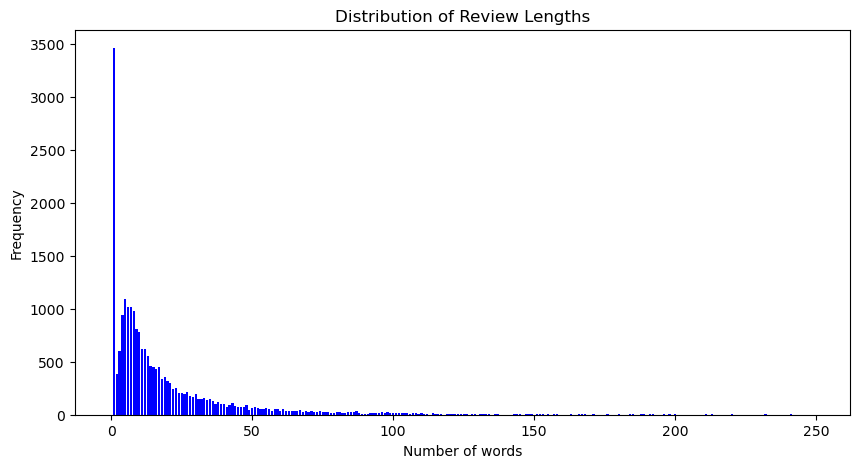

Average length of reviews based on current preprocessing: 20.092396008929793


In [9]:
# Analyse review lengths to decide on max_review_length

average_len = analyze_review_lengths(reviews)
print(f"Average length of reviews based on current preprocessing: {average_len}")

In [10]:
# Set max_review_length to 100

max_review_length = 100
print(f"Chosen max review length: {max_review_length}")

Chosen max review length: 100


In [11]:
# Split the data into training, validation, and test sets

x_train, y_train, x_val, y_val, x_test, y_test = split_data(reviews, ratings, prop_val, prop_test)

In [12]:
# Tokenisation and Padding

# Initialise the tokeniser with the size of the vocabulary (converting words into sequences of integers)
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)


# Create sequences for each set (Convert texts to integer sequences)
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_val_seq = tokenizer.texts_to_sequences(x_val)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# Pad sequences to the same length
x_train_pad = pad_sequences(x_train_seq, maxlen=max_review_length, padding='pre', truncating='post')
x_val_pad = pad_sequences(x_val_seq, maxlen=max_review_length, padding='pre', truncating='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=max_review_length, padding='pre', truncating='post')

# Convert padded sequences to NumPy arrays
x_train_pad = np.array(x_train_pad)
x_val_pad = np.array(x_val_pad)
x_test_pad = np.array(x_test_pad)

# Convert labels to NumPy arrays
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

#Display length of training, validation, and testing sets
print(f"Length of training set: {len(x_train_pad)}")
print(f"Length of validation set: {len(x_val_pad)}")
print(f"Length of testing set: {len(x_test_pad)}")


Length of training set: 13169
Length of validation set: 4390
Length of testing set: 4390


In [13]:
# Print a sample from the training data
print(x_train[1000])

# Each number corresponds to a word in the sample, where the numbers are indices that map to words in the vocabulary
print(x_train_pad[1000])

['received', 'preapproved', 'offer', 'loan', 'intent', 'look', 'refinancing', 'credit', 'card', 'debt', 'approximately', 'lower', 'interest', 'rate', 'declined', 'even', 'though', 'fico', 'score', 'adverse', 'action', 'notice', 'state', 'declined', 'mortgage', 'history', 'adverse', 'action', 'notice', 'immediately', 'given', 'decision', 'made', 'later', 'received', 'email', 'mention', 'mortgage', 'history', 'found', 'form', 'called', 'number', 'listed', 'asked', 'declined', 'fico', 'score', 'csr', 'stated', 'scoring', 'system', 'rely', 'fico', 'score', 'asked', 'adverse', 'action', 'notice', 'mentioned', 'mortgage', 'history', 'second', 'one', 'mention', 'complete', 'silence', 'believe', 'declining', 'person', 'mortgage', 'history', 'form', 'discrimination']
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0   93 1366
  158   16 2595  257  612   29    7  252 2160  467   61   42  457   32
  263 2433  303 30

# MODEL TRAINING WITH FEDERATED LEARNING USING TENSORFLOW-FEDERATED

In [14]:
# Function to split the training dataset into five simulated clients datasets

def create_federated_data(x_train_pad, y_train, num_clients=5):
    client_datasets = []
    data_per_client = len(x_train_pad) // num_clients

    for i in range(num_clients):
        start_idx = i * data_per_client
        end_idx = (i + 1) * data_per_client
        
        client_data = tf.data.Dataset.from_tensor_slices((
            x_train_pad[start_idx:end_idx], 
            tf.cast(y_train[start_idx:end_idx], tf.float32)  # Cast labels to float32 as expected by tensorflow-federated
        ))
        client_data = client_data.batch(32) 
        client_datasets.append(client_data)

        # Print the number of examples (samples) each client gets
        num_samples = end_idx - start_idx
        print(f"Client {i + 1} gets {num_samples} samples of examples.")

    #returns five labelled datasets, each containing the input data (x_train_pad) and the corresponding labels (y_train).
    return client_datasets

In [15]:
# Function that creates the model architecture of a TensorFlow-federated model.

def model_fn():
    keras_model = Sequential([
        Embedding(input_dim=max_words, output_dim=embedding_size, input_length=max_review_length),
        LSTM(units=128, return_sequences=True),
        Dropout(0.2),
        LSTM(units=64),
        Dropout(0.2),
        Dense(units=1, activation='sigmoid')  # Binary classification
    ])

    ###No need to compile the model as Tensorflow-Federated handles this

    #Return model wrapped in Tensorflow-federated format
    return tff.learning.from_keras_model(
        keras_model,
        input_spec=(tf.TensorSpec(shape=[None, max_review_length], dtype=tf.int32),
                    tf.TensorSpec(shape=[None], dtype=tf.float32)),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy()]
    )

In [16]:
# Function that defines an equivalent Keras model to be given the weights of the TensorFlow-Federated model after training for general use

def create_keras_model():
        model = Sequential()
        model.add(Embedding(input_dim=max_words, output_dim=embedding_size, input_length=max_review_length))
        model.add(LSTM(128, return_sequences=True)) 
        model.add(Dropout(0.2))
        model.add(LSTM(64))  
        model.add(Dropout(0.2))
        model.add(Dense(1, activation='sigmoid'))
        return model

In [17]:
# Class to define a custom Differential Privacy optimiser with gradient clipping and noise addition

class DPOptimizer(tf.keras.optimizers.SGD):
    
    def __init__(self, learning_rate, noise_multiplier, l2_norm_clip):
        super(DPOptimizer, self).__init__(learning_rate)
        self.noise_multiplier = noise_multiplier
        self.l2_norm_clip = l2_norm_clip

    ## Clipping threshold for the gradients so that no single input disproportionately impacts the gradient descent process. There are performance/privacy trade-offs
    def _clip_grads(self, grads):
        clipped_grads = []
        for g in grads:
            g_dense = tf.convert_to_tensor(g)  # Converts sparse gradient to dense
            clipped_g = tf.clip_by_norm(g_dense, self.l2_norm_clip)  # Clip gradients
            clipped_grads.append(clipped_g)
        return clipped_grads

    # Controls the amount of noise added
    def _add_noise(self, grads):
        noisy_grads = []
        for g in grads:
            g_dense = tf.convert_to_tensor(g)  # Converts sparse gradient to dense
            noise = tf.random.normal(shape=tf.shape(g_dense), stddev=self.noise_multiplier)
            noisy_g = g_dense + noise  # Add Gaussian noise
            noisy_grads.append(noisy_g)
        return noisy_grads

    def apply_gradients(self, grads_and_vars, name=None, experimental_aggregate_gradients=True):
        grads, vars = zip(*grads_and_vars)
        grads = self._clip_grads(grads)  # Clip gradients
        grads = self._add_noise(grads)   # Add noise to the gradients
        return super(DPOptimizer, self).apply_gradients(zip(grads, vars), name=name)


In [18]:
# Function to return the custom Differential Privacy Optimizer 

def dp_optimizer_fn(learning_rate, noise_multiplier, l2_norm_clip):
    return DPOptimizer(
        learning_rate=learning_rate,
        noise_multiplier=noise_multiplier,
        l2_norm_clip=l2_norm_clip
    )

In [19]:
#Function to calculate epsilon 

#Epsilon is the amount of privacy that can be lost as the model trains. Smaller epsilon means high privacy. High epsilon means lower privacy and an increased risk of individual model inputs being inferrable from the model output.
#Epsilon budget is the epsilon value that the particular scenario is willing to tolerate (based on security policies)

#The function approximates the epsilon value based on the Gaussian mechanism for Differential Privacy.This gives an indication of privacy loss.

def compute_epsilon(delta, noise_multiplier, num_training_steps, batch_size, dataset_size):
    q = batch_size / dataset_size  # Sampling ratio. It is the fraction of the dataset used in each batch during training. It measures how much of the total dataset is exposed at each step of training.
    steps = num_training_steps
    sigma = noise_multiplier

    # Formula for epsilon in terms of delta, noise_multiplier, steps, and q
    epsilon = math.sqrt(2 * steps * math.log(1.25 / delta)) * (q / sigma)

    return epsilon #The approximate epsilon value

In [20]:
# Create federated data

federated_train_data = create_federated_data(x_train_pad, y_train)

Client 1 gets 2633 samples of examples.
Client 2 gets 2633 samples of examples.
Client 3 gets 2633 samples of examples.
Client 4 gets 2633 samples of examples.
Client 5 gets 2633 samples of examples.


In [23]:
# Create an iterative process for federated learning, which defines how the Tensorflow-Federated model is trained on clients and how the server aggregates the updates into a Tensorflow-Federated global model

nest_asyncio.apply() #Apply nest_asyncio library to allow the code to run nested event loops, which is necessary for using TensorFlow-Federated for parallel training of the five distributed TensorFlow-federated models

# Differential privacy optimiser parameters 
l2_norm_clip = 1.0
noise_multiplier = 1.1
# learning rate of clients' model
learning_rate = 0.001


# Create an iterative process 
iterative_process = tff.learning.build_federated_averaging_process(
    #Uses function that defines the Tensorflow_federated model architecture.
    model_fn, 
    #The Differential Privacy optimizer used on the clients to update their models.
    client_optimizer_fn=lambda: dp_optimizer_fn(learning_rate, noise_multiplier, l2_norm_clip),
    #The optimizer used on the server to aggregate client updates and adjust the Tensorflow-Federated global model
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)
# Initialises the state
state = iterative_process.initialize()

C:\Users\jlwon\anaconda3\envs\tensorflow-federated_tf\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


In [24]:
# Train for several iterations of sending the Tensorflow-Federated model to each client. On each iteration, they train the model on their local data, and the models are collected and aggregated to update the Tensorflow-Federated global model.

# Lists to store the loss, accuracy and epsilon for each round
loss_history = []
accuracy_history = []
epsilon_history = []

# Differential privacy parameters. These parameters impact how fast privacy is lost during training, hence affecting epsilon value.
delta = 1e-5  # Delta represents the probability of a worst-case scenario where differential privacy guarantees might not hold. Lower delta implies stricter privacy guarantees, and higher delta means we accept a higher risk of privacy loss.
num_training_steps = 0  # Initialise the total number of training steps. The more the model trains, the more potential for privacy loss
batch_size = 32  # Batch size per client (same as used in the client datasets). Larger batch sizes relative to the dataset size may lead to more privacy leakage. 
dataset_size = len(x_train_pad)  # Total size of the training dataset. A smaller dataset size relative to the batch size increases the risk of privacy loss as more information is extracted from each sample.

num_rounds = 10

for round_num in range(1, num_rounds + 1):
    state, metrics = iterative_process.next(state, federated_train_data)  # The 'next' method runs one round of federated learning. It returns the updated state (with updated Tensorflow-Federated global model weights) and the training metrics such as accuracy and loss).
    print(f'Round {round_num}, Metrics={metrics}') # Print the metrics for each round, which indicates how the Tensorflow_Federated global model is improving.

    # Store the loss and accuracy for the round
    loss_history.append(metrics['train']['loss'])
    accuracy_history.append(metrics['train']['binary_accuracy'])

    ##Updating epsilon
    
    # Update the total number of training steps
    num_training_steps += len(federated_train_data) 

    # Compute the privacy budget (epsilon) after this round
    epsilon = compute_epsilon(delta, noise_multiplier, num_training_steps, batch_size, dataset_size)
    # Store epsilon value
    epsilon_history.append(epsilon)
    # Print the epsilon value after the round 
    print(f"Privacy budget after round {round_num}: epsilon = {epsilon}")

Round 1, Metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('binary_accuracy', 0.62725073), ('loss', 0.6833261)]))])
Privacy budget after round 1: epsilon = 0.023931274201665055
Round 2, Metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('binary_accuracy', 0.7486362), ('loss', 0.6533544)]))])
Privacy budget after round 2: epsilon = 0.03384393254086408
Round 3, Metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('binary_accuracy', 0.7486362), ('loss', 0.6292263)]))])
Privacy budget after round 3: epsilon = 0.0414501828071462
Round 4, Metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('binary_acc

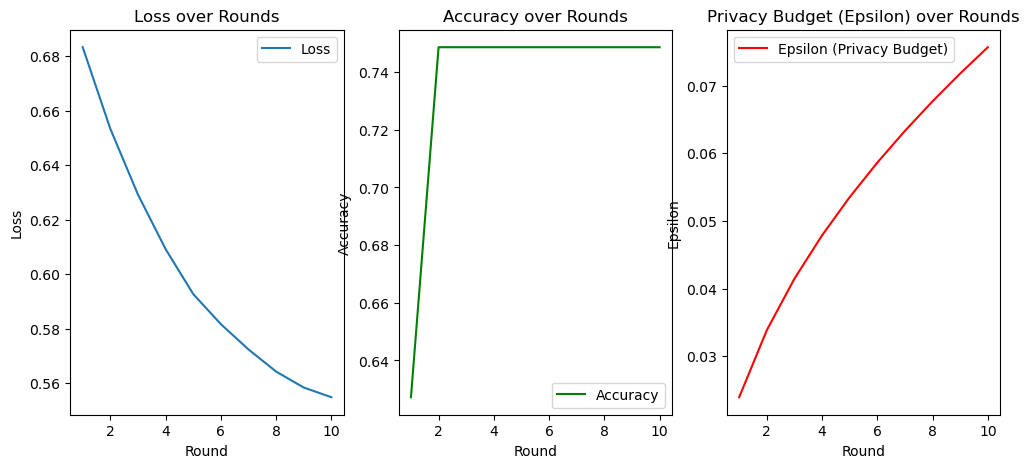

In [28]:
# Plotting the loss, accuracy and epsilon over rounds

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 3, 1)
plt.plot(range(1, num_rounds + 1), loss_history, label='Loss')
plt.title('Loss over Rounds')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 3, 2)
plt.plot(range(1, num_rounds + 1), accuracy_history, label='Accuracy', color='green')
plt.title('Accuracy over Rounds')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.legend()


# Plot epsilon
plt.subplot(1, 3, 3)
plt.plot(range(1, num_rounds + 1), epsilon_history, label='Epsilon (Privacy Budget)', color='red')
plt.title('Privacy Budget (Epsilon) over Rounds')
plt.xlabel('Round')
plt.ylabel('Epsilon')
plt.legend()

plt.show()

In [26]:
#Instantiates an equivalent Keras model to be given the weights of the TensorFlow-Federated model after its training for general use

# Retrieve the model weights from the state object (the Tensorflow-Federated component that holds the current state of the federated learning process)
model_weights = state.model.trainable

# Instantiates a Keras model
global_model=create_keras_model()

# Build the model by providing an example input (this step ensures weights are initialised)
global_model.build(input_shape=(None, max_review_length))

# Compile the Keras model
global_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Set the weights of the Tensorflow-Federated global model in the Keras global model
global_model.set_weights(model_weights)

In [27]:
# Keras Model Evaluation

# Evaluate the Keras model on the test set
global_model.evaluate(x_test_pad, y_test)

# Make predictions using the test data (probabilities between 0 and 1)
y_pred_prob = global_model.predict(x_test_pad)

# Convert predicted probabilities to binary (0 or 1) predictions
# Probabilities > 0.5 are assigned to class 1, while <= 0.5 are assigned to class 0
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate the F1 score, precision, recall, and accuracy
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Display the results
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"Epsilon (Privacy Budget): {epsilon}")

138/138 [==============================] - 6s 40ms/step - loss: 0.5455 - accuracy: 0.7569
F1 Score: 0.8616621288733307
Precision: 0.7569476082004556
Recall: 1.0
Accuracy: 0.7569476082004556
Epsilon (Privacy Budget): 0.07567733378728926
